# Trabajo Final - Econometría Espacial
## Propuesta de investigación: análisis espacial del discurso de los senadores nacionales durante la sesión extraordinaria en la que se debatía la interrupción voluntaria del embarazo
### Parte 2 del trabajo:
Ubicación de los senadores dentro del espectro político utilizando componentes princiaples a partir de las votaciones pasadas.

In [3]:
# Paquetes:
from IPython.core.display import HTML
import requests
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import datetime
import seaborn as sns
from dateutil import parser
import pytz
import pylab as pl
# %pip install pyquery
from pyquery import PyQuery as pq
import numpy as np
import scipy
import pandas as pd
from lxml import etree
import os
from os import path
from pprint import pprint
import dateutil
import json
%matplotlib inline

Antes del siguiente bloque de código, hay que ir a la terminal (Git Bash) y correr la siguiente línea de código

cd "C:\Users\lulap\Documents\Maestria\3er Trimestre\Econometria espacial\Homework\Trabajo final\Espectro-politico-senadores"

ls

bash scrape-jsons.sh

sh scrape-jsons.sh

./scrape-jsons.sh

Esto, va cambiando el número del final de la URL y va extrayendo la data

URL: http://votaciones.lanacion.com.ar/api/votacion/637

In [127]:
# Esta línea de código lee los archivos dentro de la carpeta jsons

all_motions_json = []
# for i in range(1, 637+1):
# for i in range(1, 998+1):
# for i in range(1, 2000+1):
for i in range(1, 2500+1):
    try:
        j = json.load(open('jsons/%s.json' % i))
        all_motions_json.append(j)
    except:
        pass

In [128]:
# Esta línea de código muestra la fecha de la última sesión
j['fecha']
# con 637: '01/07/2016'
# con 998: '19/10/2016'
# con 2000: '14/05/2020'
# con 2500: '16/12/2021'

'16/12/2021'

In [86]:
s_votes = []

for m in all_motions_json:
    v = m['votos']
    s = pd.DataFrame(v)
    s['sesion_id'] = m['sesion_id']
    s['datestr'] = m['fecha']
    s = s.set_index(['legislador_id', 'sesion_id'])
    s_votes.append(s)

In [87]:
df_votes = pd.concat(s_votes)

In [88]:
# Este bloque de código asigna a cada voto (string) un valor
def vote_to_number(v):
    MAPPING = {
        'AFIRMATIVO': 1, # Yes
        'AUSENTE': 0, # Absent, did not come to the session
        'NEGATIVO': -1, # No
        'ABSTENCION': 0, # person is present, but not vote
    }
    return MAPPING.get(v, 0)
    
df_votes['vote-value'] = df_votes['voto'].apply(vote_to_number)

In [89]:
from datetime import date

df_votes['date'] = df_votes['datestr'].apply(lambda x: date(
        int(x.split('/')[2]), 
        int(x.split('/')[1]), 
        int(x.split('/')[0])
    ))
df_votes['datetime'] = df_votes['date'].apply(lambda d: datetime.datetime(*d.timetuple()[:7]))

In [90]:
df_votes['date']
#10/12/2013 - 10/12/2015

# 2013-04-17 - 2016-07-01
# 2013-04-17 - 2016-10-19

legislador_id  sesion_id
288            8            2013-04-17
395            8            2013-04-17
401            8            2013-04-17
403            8            2013-04-17
404            8            2013-04-17
                               ...    
902            856          2016-10-19
224            856          2016-10-19
908            856          2016-10-19
362            856          2016-10-19
447            856          2016-10-19
Name: date, Length: 98174, dtype: object

In [91]:
s = df_votes['partido'].value_counts()
df_party_counts = pd.DataFrame(df_votes['partido'].value_counts()).reset_index()
df_party_counts.columns = ['party', 'count']
df_party_counts.to_csv('data/party-count.csv')

In [92]:
# Vemos el data frame
# df_votes

In [93]:
print('Total number of sessions:')
print(len(df_votes.reset_index()['sesion_id'].value_counts()))

Total number of sessions:
405


In [94]:
print('Total number of legislators:')
print(len(df_votes.reset_index()['legislador_id'].value_counts()))

Total number of legislators:
648


In [95]:
len(df_votes)

98174

In [96]:
df_votes.to_csv('data/votes.csv')

In [97]:
df_member_profile = df_votes.reset_index()[['legislador_id', 'agrupacion', 'agrupacion_color', 'camara', 'mail', 'nombre', 'partido']].drop_duplicates()
print(len(df_member_profile))
df_member_profile = df_member_profile.drop_duplicates('legislador_id')
print(len(df_member_profile))
df_member_profile.to_csv('data/member-profile.csv')

1201
648


In [98]:
df_member_profile[
    df_member_profile['legislador_id'] == 738
]

,legislador_id,agrupacion,agrupacion_color,camara,mail,nombre,partido
47958,738,Massismo y aliados,#b185b7,diputados,mtundis@diputados.gob.ar,"TUNDIS, MIRTA",FRENTE RENOVADOR


In [99]:
# df_member_profile.set_index('legislador_id').ix[738]

In [101]:
df_selected_votes = df_votes[
    # Me quedo con las sesiones desde 2014
    (df_votes['date'] >= date(2013, 12, 12))
    &
    # hasta 2020
    (df_votes['date'] <= date(2020, 12, 12))
]

In [102]:
len(df_selected_votes)

48251

In [103]:
df_votes_brief = df_selected_votes[['voto', 'vote-value']]

In [104]:
df_votes_brief['voto'].value_counts()

AFIRMATIVO    33403
AUSENTE        9948
NEGATIVO       3784
ABSTENCION     1116
Name: voto, dtype: int64

In [105]:
df_matrix = df_votes_brief.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')

In [106]:
df_matrix = df_matrix.fillna(0)

In [107]:
df_matrix.to_csv('data/matrix-2013-2015.csv')

In [108]:
df_matrix.shape

(461, 210)

#### Componentes princiaples

In [109]:
# X = np.matrix(df_matrix.fillna(0).as_matrix()).astype('int8')
# X = np.matrix.astype('int8')
# X = np.matrix
X = np.matrix(df_matrix.fillna(0).astype('int8'))

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
df_pc = pd.DataFrame(X_reduced, index=df_matrix.index, columns=['PC1', 'PC2', 'PC3'])

In [111]:
pca.explained_variance_

array([23.56844129,  9.22874008,  5.43217777])

Watch out:
* The explained variance by PC1 to PC3 is very small in this data set
* The data set is highly non-linear

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

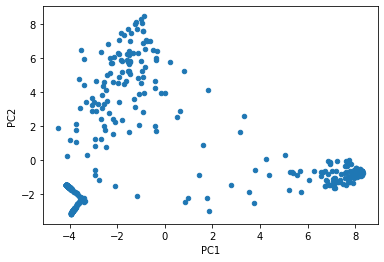

In [112]:
%matplotlib inline
df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [113]:
df_party_count_color = pd.read_csv('data/party-count-color.csv')

In [114]:
len(df_pc)

461

In [115]:
len(df_member_profile)

648

In [116]:
df_pc_member = pd.merge(df_pc.reset_index(), df_member_profile, how='left',
                        left_on='legislador_id', right_on='legislador_id')

In [117]:
len(df_pc_member)

461

In [118]:
len(df_pc)

461

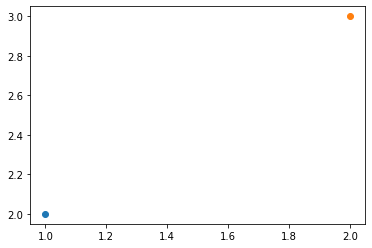

In [119]:
plt.scatter(1, 2)
plt.scatter(2, 3)

('', '')
('Cambiemos', '#FEDB30')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo y aliados..', '#007caf')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('Progresismo', '#CECA7A')
('UNEN - FAP - UCR', '#8eab35')


Text(0, 0.5, 'PC2')

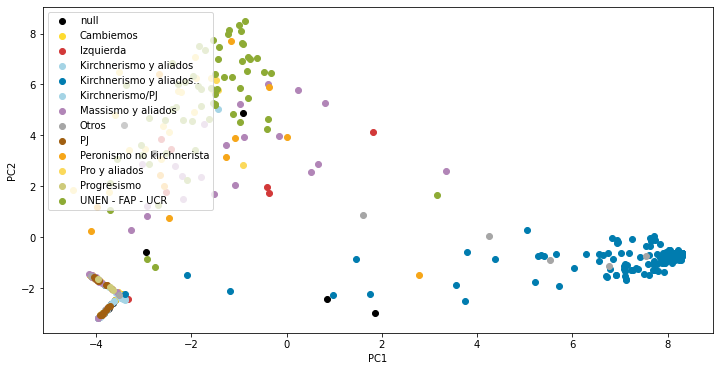

In [120]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

('', '')
('Cambiemos', '#FEDB30')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo y aliados..', '#007caf')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('Progresismo', '#CECA7A')
('UNEN - FAP - UCR', '#8eab35')


Text(0, 0.5, 'PC2')

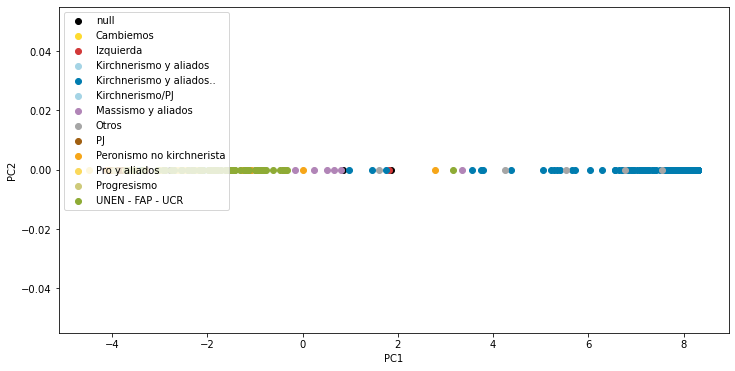

In [121]:
%matplotlib inline

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], [0] * len(group['PC1']), color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [122]:
df_pc_member['legislador_id'] = df_pc_member['legislador_id'].apply(lambda x: str(x))
open('data/pc-member-3d.json', 'w').write(json.dumps(
    df_pc_member.set_index('legislador_id').T.to_dict()
    ))

133420

In [123]:
df_pc_member

,legislador_id,PC1,PC2,PC3,agrupacion,agrupacion_color,camara,mail,nombre,partido
0,1,1.452397,-0.847793,-2.502009,Kirchnerismo y aliados..,#007caf,diputados,nabdaladem@diputados.gob.ar,"Abdala de Matarazzo, Norma Amanda",FRENTE CÍVICO POR SANTIAGO
1,8,-2.542766,3.320281,2.589115,UNEN - FAP - UCR,#8eab35,diputados,oaguad@diputados.gob.ar,"Aguad, Oscar Raúl",UNIÓN CÍVICA RADICAL
2,10,0.007738,3.954861,2.537448,Peronismo no kirchnerista,#f6a619,diputados,laguilar@diputados.gob.ar,"AGUILAR, Lino Walter",FRENTE PERONISTA
3,11,-3.817941,-2.914577,3.033830,,,diputados,hilda.aguirre@senado.gov.ar,"AGUIRRE., Hilda Clelia",
4,19,-1.508608,5.643373,-1.628710,UNEN - FAP - UCR,#8eab35,diputados,ralfonsin@diputados.gob.ar,"ALFONSÍN, Ricardo Luis",UNIÓN CÍVICA RADICAL
...,...,...,...,...,...,...,...,...,...,...
456,1234,-0.815193,5.475700,-1.657129,UNEN - FAP - UCR,#8eab35,diputados,mscarrizo@diputados.gob.ar,"Carrizo, Soledad",
457,1267,-3.534979,-2.276068,-0.928917,,,diputados,dmartinez@diputados.gob.ar,"MartÍNez, DaríO",
458,1317,-0.613899,7.040728,3.073829,UNEN - FAP - UCR,#8eab35,diputados,mfiad@diputados.gob.ar,"Fiad, Mario R.",UNIÓN CÍVICA RADICAL
459,1320,-1.134964,4.850990,2.738385,UNEN - FAP - UCR,#8eab35,diputados,jmartinez@diputados.gob.ar,"MartÍNez, Julio",UNIÓN CÍVICA RADICAL


('', '')
('Cambiemos', '#FEDB30')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo y aliados..', '#007caf')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('Progresismo', '#CECA7A')
('UNEN - FAP - UCR', '#8eab35')


8

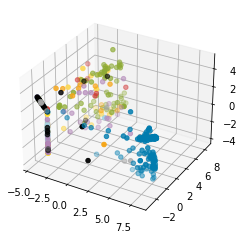

In [124]:
%matplotlib inline

x = np.array(X_reduced.T[0, :]).astype('float')
y = np.array(X_reduced.T[1, :]).astype('float')
z = np.array(X_reduced.T[2, :]).astype('float')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], group['PC3'], color=gname[1], label=gname[0])
#ax.scatter(x, y, z, picker=True, s=100)

def onpick(X_3D, event):
    #print(event)
    if hasattr(onpick, '_label'):
        #pass
        onpick._label.remove()
    thisline = event.artist
    ind = event.ind
    #print(type(ind))
    #print(X_3D[0, ind])
    names = df_matrix.iloc[ind].index.values
    #print(names)
    label = ('\n'.join(names))
    pos = (X_3D[0, ind[0]], X_3D[1, ind[0]], X_3D[2, ind[0]])
    #onpick._label = ax.set_title(label
    onpick._label = ax.text(*pos, s=label)
    fig.canvas.draw()
    
fig.canvas.mpl_connect('pick_event', lambda e: onpick(X_reduced.T, e))